In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv("patient_dataset.csv")

In [4]:
# Adım 1: Genel resmi inceledim

def check_df(dataframe, head=5):
    print(dataframe.head())
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.isnull().sum())
    print("############################################")
    numeric_df = dataframe.select_dtypes(include=[np.number])
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

   age  gender  chest_pain_type  blood_pressure  cholesterol  max_heart_rate  exercise_angina  plasma_glucose  skin_thickness  insulin    bmi  diabetes_pedigree  hypertension  heart_disease residence_type smoking_status
0   24   1.000                4             250          139             212                0         108.000          33.000  109.000 37.999              0.480             1              1          Urban         Smoker
1   29   0.000                4             132          187             147                0         202.000          42.000      NaN 25.588              0.284             1              1          Urban        Unknown
2   46   0.000                3             271          185             193                0         149.000          43.000  102.000 37.892              2.472             1              0          Rural     Non-Smoker
3   73     NaN                2             102          200             125                0         105.000          7

In [5]:
df_cleaning = df.copy()
df_cleaning = df_cleaning.dropna()
df_cleaning.isnull().sum()

age                  0
gender               0
chest_pain_type      0
blood_pressure       0
cholesterol          0
max_heart_rate       0
exercise_angina      0
plasma_glucose       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
hypertension         0
heart_disease        0
residence_type       0
smoking_status       0
dtype: int64

In [6]:
mk = LabelEncoder()
df_cleaning['residence_type'] = mk.fit_transform(df_cleaning['residence_type'])
df_cleaning['smoking_status'] = mk.fit_transform(df_cleaning['smoking_status'])

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes != 'O') and
                                                     (dataframe[col].nunique() < cat_th))]
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') and
                                                       (dataframe[col].nunique() > car_th))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if col not in "Patient No."]
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [8]:
# Adım 3:  kategorik ve Numerik değişkenlerin analizini yaptım

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(df, col)

                residence_type  Ratio
residence_type                       
Urban                     2778 46.300
Rural                     2767 46.117
                smoking_status  Ratio
smoking_status                       
Smoker                    2786 46.433
Non-Smoker                2738 45.633
Unknown                    476  7.933
        gender  Ratio
gender               
0.000     2777 46.283
1.000     2751 45.850
                 chest_pain_type  Ratio
chest_pain_type                        
4                           1557 25.950
1                           1484 24.733
3                           1481 24.683
2                           1478 24.633
                 exercise_angina  Ratio
exercise_angina                        
1                           3019 50.317
0                           2981 49.683
              hypertension  Ratio
hypertension                     
1                     3008 50.133
0                     2992 49.867
               heart_disease  Rati

In [9]:
#Eksik değerlerin sayısı ve oranı
def miss_value_table(dataframe, na__name=False):
    n_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[n_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[n_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")
    if na__name:
        return n_columns

n_columns = miss_value_table(df, True)

                n_miss  ratio
skin_thickness     614 10.230
plasma_glucose     609 10.150
insulin            568  9.470
gender             472  7.870
residence_type     455  7.580



count   6000.000
mean      53.658
std       21.018
min       18.000
5%        21.000
10%       25.000
20%       32.000
30%       39.000
40%       46.000
50%       53.000
60%       60.000
70%       68.000
80%       76.000
90%       83.000
95%       87.000
99%       90.000
100%      90.000
max       90.000
Name: age, dtype: float64


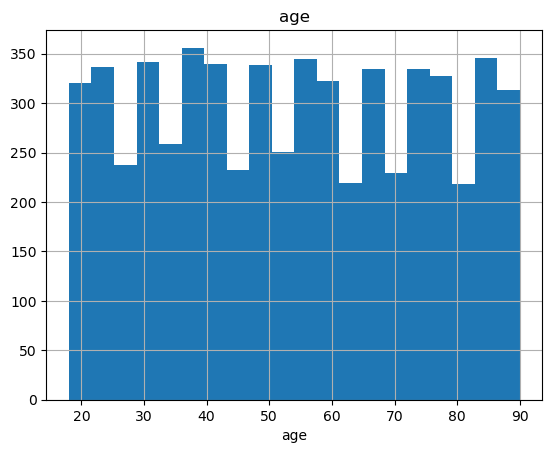

count   6000.000
mean     134.277
std       48.303
min        0.000
5%        32.000
10%       93.000
20%      103.000
30%      114.000
40%      124.000
50%      135.000
60%      145.000
70%      156.000
80%      166.000
90%      176.000
95%      217.000
99%      283.000
100%     300.000
max      300.000
Name: blood_pressure, dtype: float64


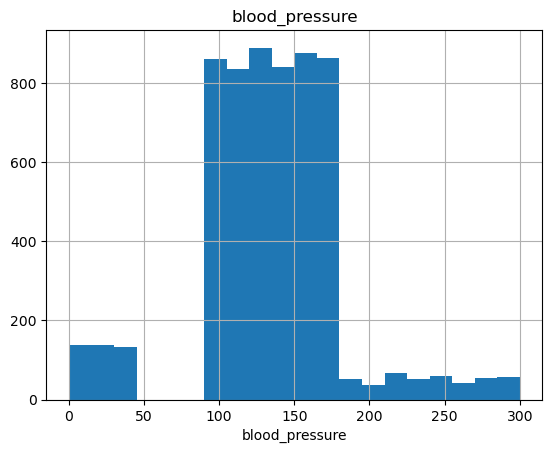

count   6000.000
mean     209.845
std       52.840
min      120.000
5%       128.000
10%      137.000
20%      155.000
30%      173.000
40%      190.000
50%      210.000
60%      228.000
70%      247.000
80%      265.000
90%      282.000
95%      292.000
99%      299.000
100%     300.000
max      300.000
Name: cholesterol, dtype: float64


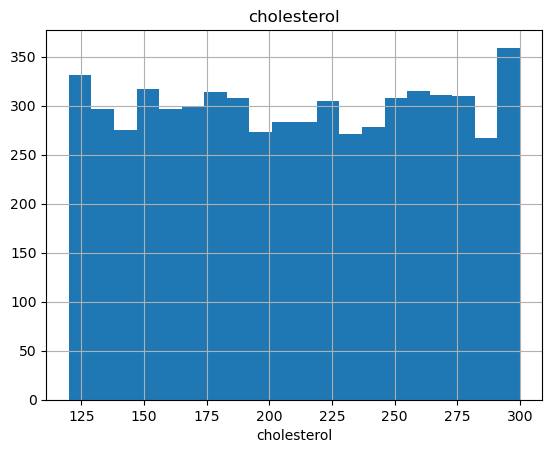

count   6000.000
mean     144.996
std       43.583
min       70.000
5%        77.000
10%       85.000
20%      101.000
30%      115.000
40%      130.000
50%      144.000
60%      160.000
70%      175.000
80%      190.000
90%      206.000
95%      213.000
99%      219.000
100%     220.000
max      220.000
Name: max_heart_rate, dtype: float64


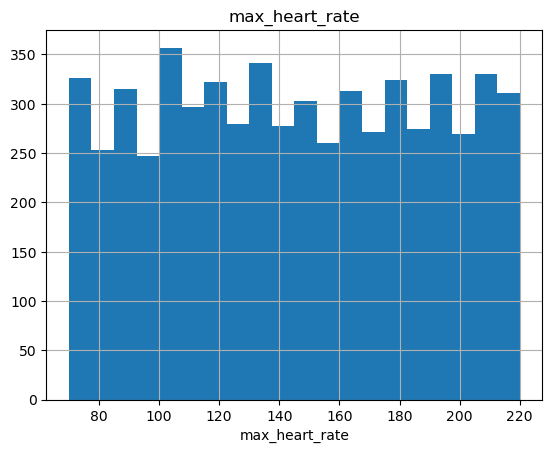

count   5391.000
mean     161.120
std       52.435
min       70.000
5%        78.000
10%       88.000
20%      106.000
30%      125.000
40%      143.000
50%      162.000
60%      181.000
70%      198.000
80%      215.000
90%      232.000
95%      242.000
99%      248.100
100%     250.000
max      250.000
Name: plasma_glucose, dtype: float64


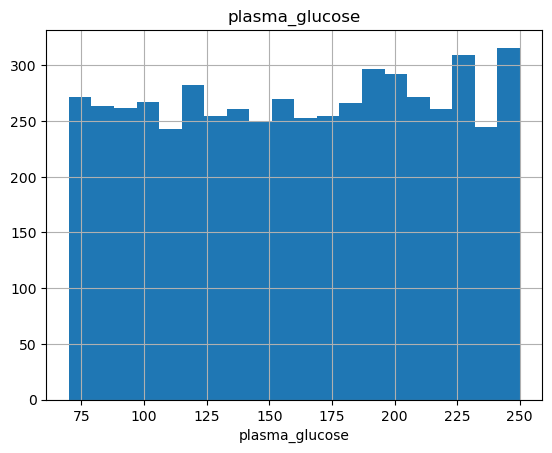

count   5386.000
mean      59.965
std       23.264
min       20.000
5%        24.000
10%       28.000
20%       36.000
30%       44.000
40%       52.000
50%       60.000
60%       68.000
70%       76.000
80%       84.000
90%       92.000
95%       96.000
99%      100.000
100%     100.000
max      100.000
Name: skin_thickness, dtype: float64


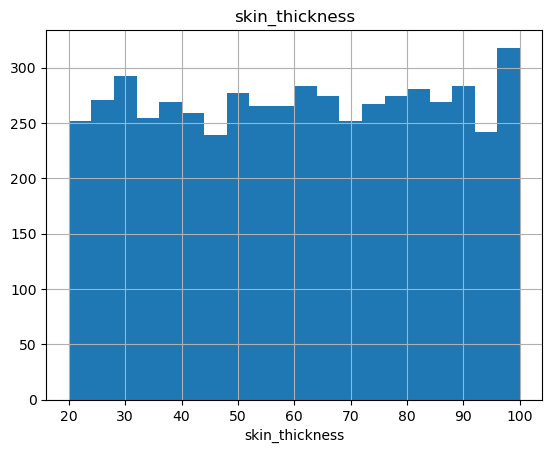

count   5432.000
mean     129.601
std       29.207
min       80.000
5%        84.000
10%       89.000
20%      100.000
30%      109.000
40%      120.000
50%      129.000
60%      139.000
70%      150.000
80%      160.000
90%      171.000
95%      176.000
99%      179.000
100%     180.000
max      180.000
Name: insulin, dtype: float64


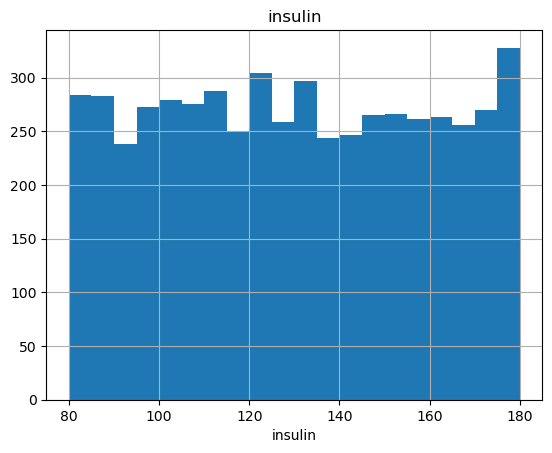

count   6000.000
mean      29.941
std       11.626
min       10.007
5%        11.976
10%       13.818
20%       17.823
30%       21.753
40%       25.909
50%       29.940
60%       34.082
70%       38.143
80%       42.022
90%       46.039
95%       48.063
99%       49.510
100%      49.999
max       49.999
Name: bmi, dtype: float64


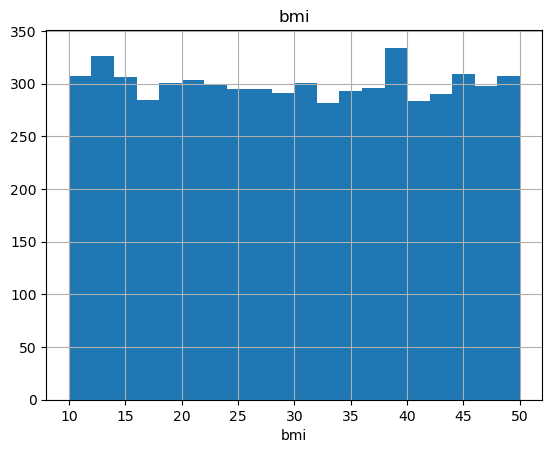

count   6000.000
mean       1.295
std        0.690
min        0.100
5%         0.219
10%        0.338
20%        0.570
30%        0.809
40%        1.063
50%        1.294
60%        1.532
70%        1.770
80%        2.009
90%        2.254
95%        2.364
99%        2.465
100%       2.500
max        2.500
Name: diabetes_pedigree, dtype: float64


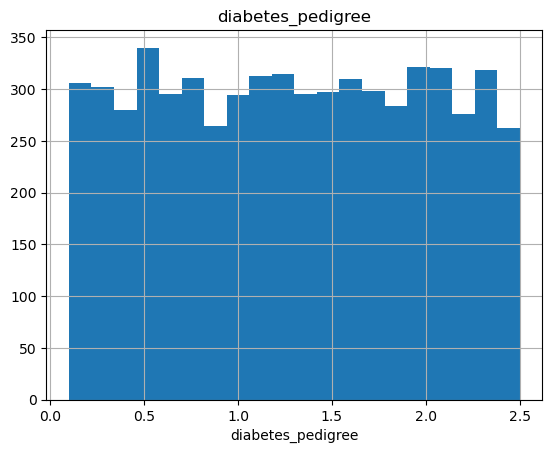

In [10]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

In [11]:
#residence_type sütununun diğer sütunlarla bağımsız mı
attributes = list(df_cleaning.columns.values)

for i in attributes:
    crosstab = pd.crosstab(df_cleaning['residence_type'], df_cleaning[i])
    chi2, p, dof, ex = stats.chi2_contingency(crosstab)
    #result = pd.DataFrame({"attribute": i, "chi2": chi2, "pvalue" : p, "dof" : dof})
    #chi_square_result.append(result)
    print(f"Chi2 result of the contingency table for attribute {i}: {chi2}, p-value: {p}, dof: {dof}")

Chi2 result of the contingency table for attribute age: 73.26258167057728, p-value: 0.43639403678548244, dof: 72
Chi2 result of the contingency table for attribute gender: 0.9679351624115444, p-value: 0.3251956838292833, dof: 1
Chi2 result of the contingency table for attribute chest_pain_type: 1.0458771014058836, p-value: 0.7901529446900053, dof: 3
Chi2 result of the contingency table for attribute blood_pressure: 208.3878067713751, p-value: 0.7349629576318354, dof: 222
Chi2 result of the contingency table for attribute cholesterol: 169.3329433850387, p-value: 0.7048450608061946, dof: 180
Chi2 result of the contingency table for attribute max_heart_rate: 129.84481832555002, p-value: 0.8812658020995889, dof: 150
Chi2 result of the contingency table for attribute exercise_angina: 0.6200747455510498, p-value: 0.43101951140777306, dof: 1
Chi2 result of the contingency table for attribute plasma_glucose: 202.65357768186078, p-value: 0.11859577871936826, dof: 180
Chi2 result of the continge

In [12]:
#smoking_status sütununun diğer sütunlarla olan bağımsızlığını test ettim.
attributes2 = list(df_cleaning.columns.values)

for i in attributes2:
    crosstab = pd.crosstab(df_cleaning['smoking_status'], df_cleaning[i])
    chi2, p, dof, ex = stats.chi2_contingency(crosstab)
    print(f"Chi2 result of the contingency table for attribute {i}: {chi2}, p-value: {p}, dof: {dof}")

Chi2 result of the contingency table for attribute age: 135.27993780497548, p-value: 0.6861939418168094, dof: 144
Chi2 result of the contingency table for attribute gender: 1.2089517687713023, p-value: 0.5463607077889647, dof: 2
Chi2 result of the contingency table for attribute chest_pain_type: 1.1709972647665094, p-value: 0.9782930055701569, dof: 6
Chi2 result of the contingency table for attribute blood_pressure: 387.68440550093516, p-value: 0.9746254904917692, dof: 444
Chi2 result of the contingency table for attribute cholesterol: 350.1778475202018, p-value: 0.6347752436950391, dof: 360
Chi2 result of the contingency table for attribute max_heart_rate: 265.3915537599581, p-value: 0.9255883315362272, dof: 300
Chi2 result of the contingency table for attribute exercise_angina: 3.353965240997656, p-value: 0.18693718633655002, dof: 2
Chi2 result of the contingency table for attribute plasma_glucose: 383.35478440054715, p-value: 0.1902546794389598, dof: 360
Chi2 result of the contingen

In [13]:
df_cleaning = df_cleaning.drop(['residence_type'], axis=1)
df_cleaning['gender'] = df_cleaning['gender'].astype(int)
df_cleaning[0:10]

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,smoking_status
0,24,1,4,250,139,212,0,108.000,33.000,109.000,37.999,0.480,1,1,1
2,46,0,3,271,185,193,0,149.000,43.000,102.000,37.892,2.472,1,0,0
4,49,1,3,91,163,192,0,162.000,31.000,170.000,12.768,0.538,1,1,1
5,63,1,3,18,154,107,0,103.000,67.000,102.000,22.374,1.062,0,0,0
7,37,1,4,263,201,201,0,186.000,21.000,180.000,35.663,0.151,0,0,1
9,77,1,1,138,217,201,0,199.000,100.000,132.000,18.394,1.825,1,0,0
10,50,0,3,109,223,182,0,110.000,30.000,109.000,47.869,1.429,0,1,1
12,81,0,4,170,259,220,1,114.000,92.000,125.000,48.156,0.185,1,0,1
14,73,1,4,156,134,186,0,214.000,56.000,83.000,34.670,1.229,0,0,1
15,68,0,1,135,193,146,1,232.000,92.000,172.000,12.234,0.448,1,0,0


In [14]:
#StandardScaler ile veri setini standartlaştırma
df_std = df_cleaning.copy()
cat_columns = ['age','chest_pain_type','gender','hypertension','heart_disease', 'smoking_status']

std_scaler = StandardScaler()
le = LabelEncoder()

for col in cat_columns:
    df_std[col] = le.fit_transform(df_std[col])

df_std = std_scaler.fit_transform(df_std)
df_std

array([[-1.41054508,  1.00968806,  1.32838557, ...,  1.01402442,
         0.98722672,  0.59451675],
       [-0.36638608, -0.9904049 ,  0.43465733, ...,  1.01402442,
        -1.01293854, -1.00716113],
       [-0.22400076,  1.00968806,  0.43465733, ...,  1.01402442,
         0.98722672,  0.59451675],
       ...,
       [-0.12907721,  1.00968806, -0.45907091, ..., -0.98616955,
         0.98722672, -1.00716113],
       [ 0.77269647, -0.9904049 , -0.45907091, ..., -0.98616955,
         0.98722672, -1.00716113],
       [ 1.15239066, -0.9904049 , -0.45907091, ...,  1.01402442,
        -1.01293854, -1.00716113]])

In [15]:
#MinMaxScaler ile veri setini standartlaştırma

df_mm = df_cleaning.copy()

mm_scaler = MinMaxScaler(feature_range=(-1,1))

for col in cat_columns:
    df_mm[col] = le.fit_transform(df_mm[col])

df_mm = mm_scaler.fit_transform(df_mm)
df_mm

array([[-0.83333333,  1.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.22222222, -1.        ,  0.33333333, ...,  1.        ,
        -1.        , -1.        ],
       [-0.13888889,  1.        ,  0.33333333, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.08333333,  1.        , -0.33333333, ..., -1.        ,
         1.        , -1.        ],
       [ 0.44444444, -1.        , -0.33333333, ..., -1.        ,
         1.        , -1.        ],
       [ 0.66666667, -1.        , -0.33333333, ...,  1.        ,
        -1.        , -1.        ]])

In [16]:
# K MEANS ALGORİTMASI
pca = PCA(n_components=2)
X_std = pca.fit_transform(df_std)
X_mm = pca.fit_transform(df_mm)
X_std

array([[ 2.65288125,  0.14152633],
       [ 1.6211516 , -0.82532938],
       [ 1.18124931, -0.17204638],
       ...,
       [-0.85746194, -0.44583999],
       [-1.31550306,  0.74701838],
       [ 0.66042829, -0.50415478]])

C:\Users\kerem\AppData\Local\Temp\ipykernel_3984\337023784.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


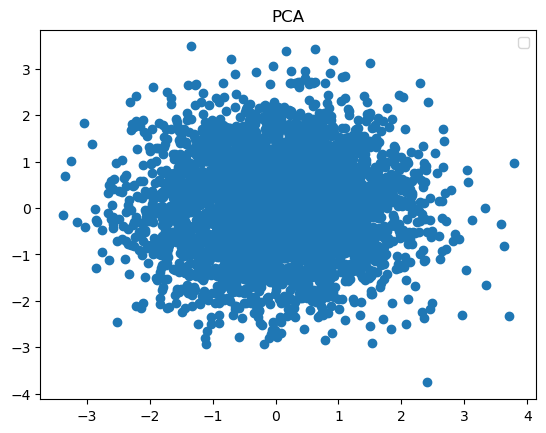

In [17]:
plt.scatter(X_std[: , 0] ,X_std[: , 1])
plt.legend()
plt.title('PCA')
plt.show()

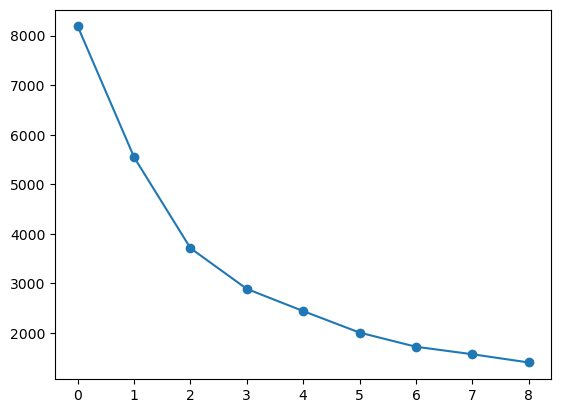

In [18]:
wcss_1 = []                                     
range_values = range(1, 10)                    
for i in range_values:                        
  kmeans = KMeans(n_clusters=i)                 
  kmeans.fit(X_std)            
  wcss_1.append(kmeans.inertia_) 

grafico = px.line(x = range(1,10), y = wcss_1)
plt.plot(wcss_1, '-o',)
grafico.show()

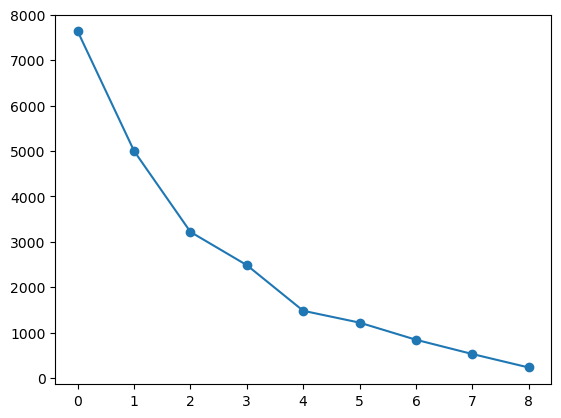

In [19]:
wcss_2 = []                                     
range_values = range(1, 10)                    
for i in range_values:                        
  kmeans = KMeans(n_clusters=i)                 
  kmeans.fit(X_mm)            
  wcss_2.append(kmeans.inertia_) 

grafico = px.line(x = range(1,10), y = wcss_2)
plt.plot(wcss_2, '-o',)  
grafico.show()

In [20]:
#Elbow method shows clusters = 3
#Below, author compares kmeans and kmeans++ approaches in K Means, and comparing the results from StandardScaler and MinMaxScaler

In [21]:
k = 3

# Compute KMeans
kmeans_std = KMeans(n_clusters = k, n_init=1, init = 'random', max_iter=50).fit(X_std)

# Compute KMeans++
kmeans_plus_std = KMeans(n_clusters = k, n_init=1, init = 'k-means++', max_iter=50).fit(X_std)

# Compute KMeans
kmeans_mm = KMeans(n_clusters = k, n_init=1, init = 'random', max_iter=50).fit(X_mm)

# Compute KMeans++
kmeans_plus_mm = KMeans(n_clusters = k, n_init=1, init = 'k-means++', max_iter=50).fit(X_mm)

In [22]:
labels_kmeans_std = kmeans_std.labels_
labels_kmeans_plus_std = kmeans_plus_std.labels_
labels_kmeans_mm = kmeans_mm.labels_
labels_kmeans_plus_mm = kmeans_plus_mm.labels_

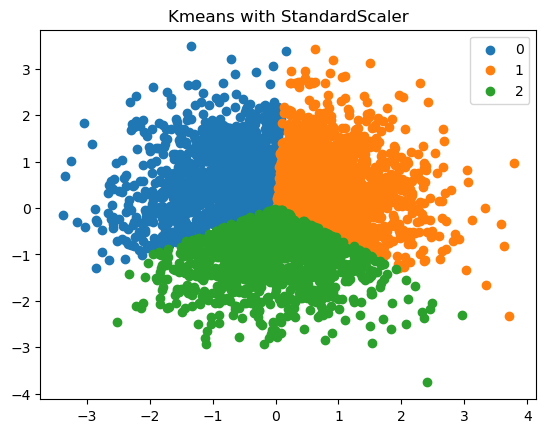

Inertia k-Means with StandardScaler: 3736.0091829183284
Silhouette_score k-Means with StandardScaler : 0.3306480754555499
Davies_bouldin_score k-Means with StandardScaler : 0.9419135554995209


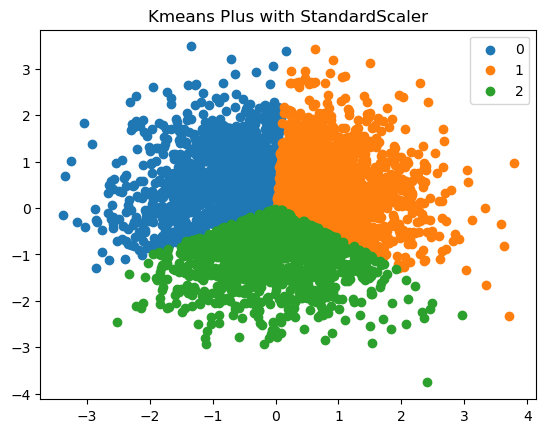

Inertia k-Means++ with StandardScaler: 3736.9423658843984
Silhouette_score k-Means++ with StandardScaler: 0.33102143503581927
Davies_bouldin_score k-Means++ with StandardScaler : 0.9376728250140833


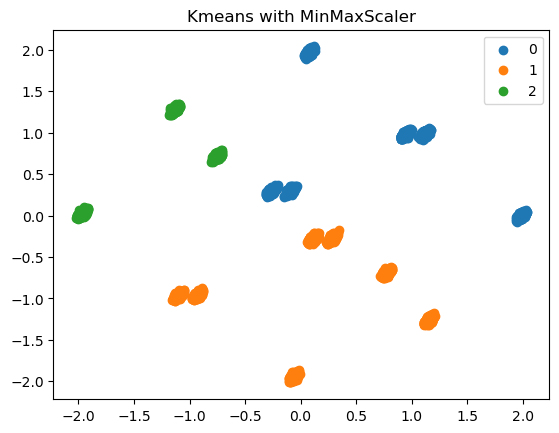

Inertia k-Means with MinMaxScaler: 3330.7907226418592
Silhouette_score k-Means with MinMaxScaler : 0.3931748637537917
Davies_bouldin_score k-Means with MinMaxScaler : 1.1489041284270332


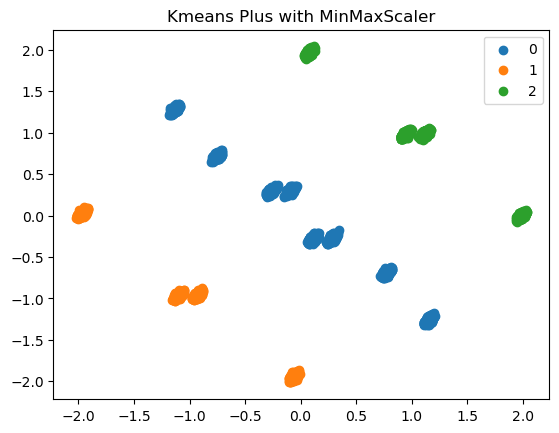

Inertia k-Means++ with MinMaxScaler: 3830.2434456023966
Silhouette_score k-Means++ with MinMaxScaler: 0.41617223291974553
Davies_bouldin_score k-Means with MinMaxScaler : 1.1489041284270332


In [23]:
u_labels = np.unique(labels_kmeans_std)

for i in u_labels:
    xy = X_std[labels_kmeans_plus_std == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans with StandardScaler')
plt.show()

print("Inertia k-Means with StandardScaler:", kmeans_std.inertia_)
print("Silhouette_score k-Means with StandardScaler :",silhouette_score(X_std, labels_kmeans_std))
print("Davies_bouldin_score k-Means with StandardScaler :",davies_bouldin_score(X_std, labels_kmeans_std))

u_labels = np.unique(labels_kmeans_plus_std)

for i in u_labels:
    xy = X_std[labels_kmeans_plus_std == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans Plus with StandardScaler')
plt.show()

print("Inertia k-Means++ with StandardScaler:", kmeans_plus_std.inertia_)
print("Silhouette_score k-Means++ with StandardScaler:",silhouette_score(X_std, labels_kmeans_plus_std))
print("Davies_bouldin_score k-Means++ with StandardScaler :",davies_bouldin_score(X_std, labels_kmeans_plus_std))

u_labels = np.unique(labels_kmeans_mm)

for i in u_labels:
    plt.scatter(X_mm[labels_kmeans_mm == i , 0] , X_mm[labels_kmeans_mm == i , 1] , label = i)
plt.legend()
plt.title('Kmeans with MinMaxScaler')
plt.show()

print("Inertia k-Means with MinMaxScaler:", kmeans_mm.inertia_)
print("Silhouette_score k-Means with MinMaxScaler :",silhouette_score(X_mm, labels_kmeans_mm))
print("Davies_bouldin_score k-Means with MinMaxScaler :",davies_bouldin_score(X_mm, labels_kmeans_plus_mm))

u_labels = np.unique(labels_kmeans_plus_mm)

for i in u_labels:
    plt.scatter(X_mm[labels_kmeans_plus_mm == i , 0] , X_mm[labels_kmeans_plus_mm == i , 1] , label = i)
plt.legend()
plt.title('Kmeans Plus with MinMaxScaler')
plt.show()

print("Inertia k-Means++ with MinMaxScaler:", kmeans_plus_mm.inertia_)
print("Silhouette_score k-Means++ with MinMaxScaler:",silhouette_score(X_mm, labels_kmeans_plus_mm))
print("Davies_bouldin_score k-Means with MinMaxScaler :",davies_bouldin_score(X_mm, labels_kmeans_plus_mm))

In [24]:
#Optimizing K Means
#Trial to see the effect of optimized PCA
#I tried using standardscaler data only

In [25]:
df_cleaning2 = df_cleaning.copy()
df_cleaning2 = df_cleaning2.drop(['gender'], axis=1)
df_cleaning2 = df_cleaning2.drop(['smoking_status'], axis=1)
df_cleaning2 = df_cleaning2.drop(['bmi'], axis=1)
df_cleaning2 = df_cleaning2.drop(['skin_thickness'], axis=1)

In [26]:
df_std2 = df_cleaning2.copy()
cat_columns = ['age', 'chest_pain_type', 'hypertension', 'heart_disease']

std_scaler = StandardScaler()
le = LabelEncoder()

for col in cat_columns:
    df_std2[col] = le.fit_transform(df_std2[col])

df_std2 = std_scaler.fit_transform(df_std2)
df_std2
#Testing on Manually Reduced Dimensions, based on assumption: heart_disease, hypertension, diabetes_pedigree, insulin, max_heart_rate, blood_pressure, age, chest_pain_type as the main decision maker

array([[-1.41054508,  1.32838557,  2.43864014, ..., -1.18010782,
         1.01402442,  0.98722672],
       [-0.36638608,  0.43465733,  2.88072947, ...,  1.69715177,
         1.01402442, -1.01293854],
       [-0.22400076,  0.43465733, -0.90860762, ..., -1.09727374,
         1.01402442,  0.98722672],
       ...,
       [-0.12907721, -0.45907091,  0.81764594, ..., -0.02974242,
        -0.98616955,  0.98722672],
       [ 0.77269647, -0.45907091, -0.29810331, ..., -0.94070899,
        -0.98616955,  0.98722672],
       [ 1.15239066, -0.45907091, -0.06653271, ..., -0.83516275,
         1.01402442, -1.01293854]])

C:\Users\kerem\AppData\Local\Temp\ipykernel_3984\2659154493.py:4: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



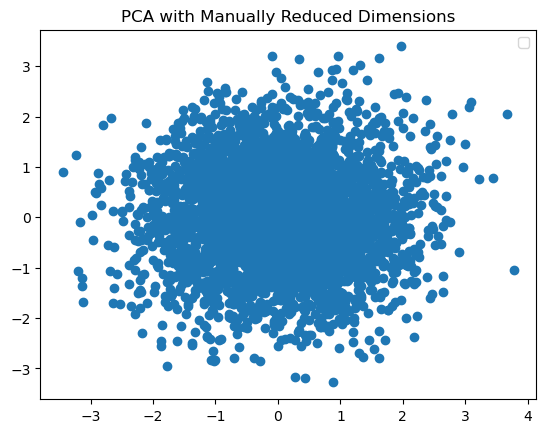

In [27]:
pca2 = PCA()
X_std2 = pca2.fit_transform(df_std2)
plt.scatter(X_std2[: , 0] ,X_std2[: , 1])
plt.legend()
plt.title('PCA with Manually Reduced Dimensions')
plt.show()
#Dataset is now less dense after minimizing the dimensions

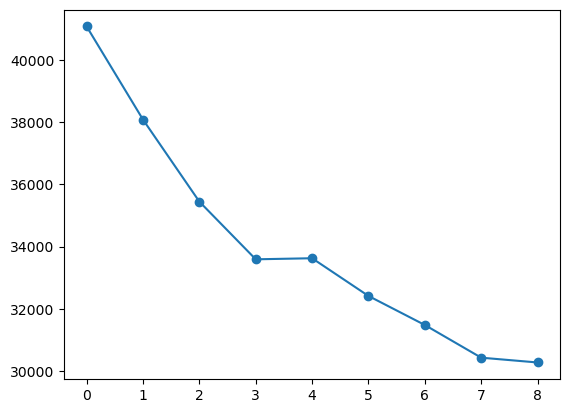

In [28]:
wcss_1 = []                                     
range_values = range(1, 10)                    
for i in range_values:                        
  kmeans = KMeans(n_clusters=i)                 
  kmeans.fit(X_std2)            
  wcss_1.append(kmeans.inertia_) 

grafico = px.line(x = range(1,10), y = wcss_1)
plt.plot(wcss_1, '-o',)  
grafico.show()
#Elbow shows 3

In [29]:
k = 3

# Compute KMeans
kmeans_std2 = KMeans(n_clusters = k, n_init=1, init = 'random', max_iter=50).fit(X_std2)

# Compute KMeans++
kmeans_plus_std2 = KMeans(n_clusters = k, n_init=1, init = 'k-means++', max_iter=50).fit(X_std2)
labels_kmeans_std2 = kmeans_std2.labels_
labels_kmeans_plus_std2 = kmeans_plus_std2.labels_

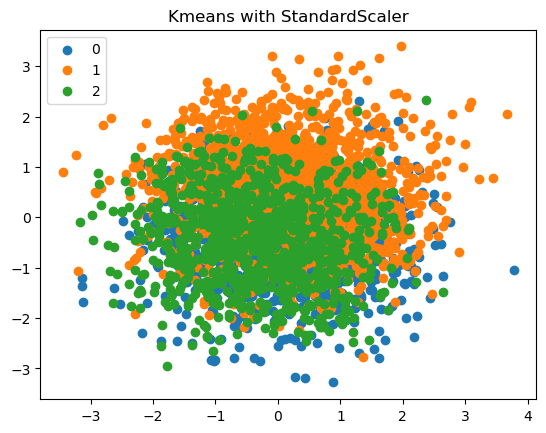

Inertia k-Means with StandardScaler: 36090.37848841853
Silhouette_score k-Means with StandardScaler : 0.06655327513549215
Davies_bouldin_score k-Means with StandardScaler : 3.3897272388963255


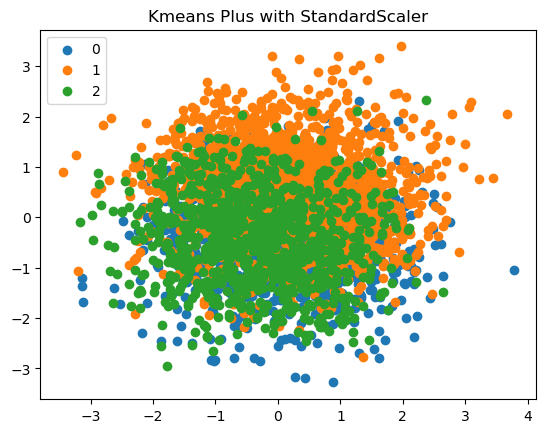

Inertia k-Means++ with StandardScaler: 35435.28296006736
Silhouette_score k-Means++ with StandardScaler: 0.07809243779413477
Davies_bouldin_score k-Means++ with StandardScaler : 2.8839317026959717


In [30]:
u_labels = np.unique(labels_kmeans_std2)

for i in u_labels:
    xy = X_std2[labels_kmeans_plus_std2 == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans with StandardScaler')
plt.show()

print("Inertia k-Means with StandardScaler:", kmeans_std2.inertia_)
print("Silhouette_score k-Means with StandardScaler :",silhouette_score(X_std2, labels_kmeans_std2))
print("Davies_bouldin_score k-Means with StandardScaler :",davies_bouldin_score(X_std2, labels_kmeans_std2))

u_labels = np.unique(labels_kmeans_plus_std2)

for i in u_labels:
    xy = X_std2[labels_kmeans_plus_std2 == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans Plus with StandardScaler')
plt.show()

print("Inertia k-Means++ with StandardScaler:", kmeans_plus_std2.inertia_)
print("Silhouette_score k-Means++ with StandardScaler:",silhouette_score(X_std2, labels_kmeans_plus_std2))
print("Davies_bouldin_score k-Means++ with StandardScaler :",davies_bouldin_score(X_std2, labels_kmeans_plus_std2))
#Optimized PCA, getting the components that can represent 95% of the variance

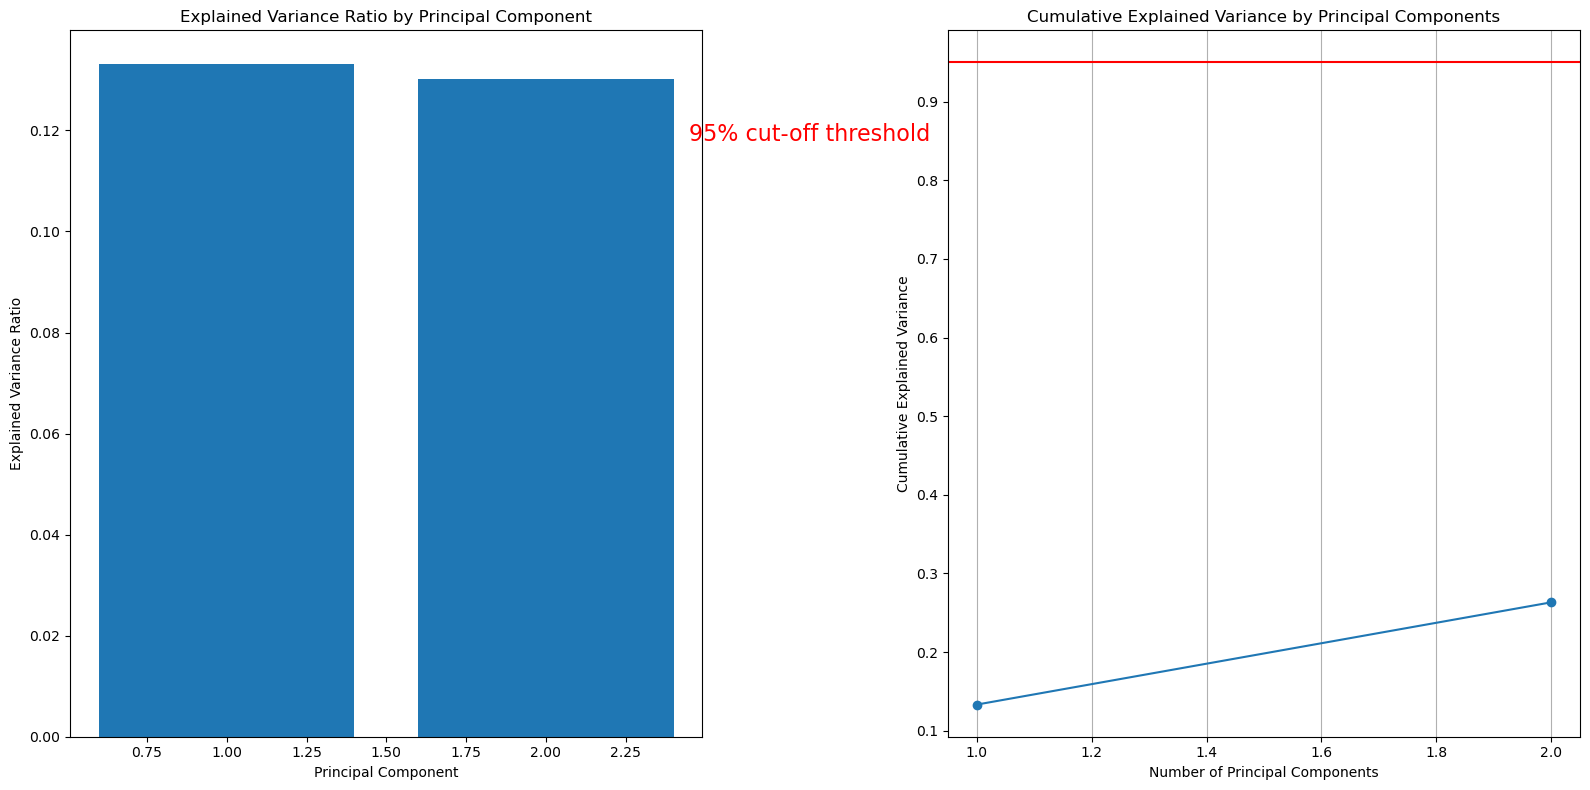

In [31]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")
#95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax2.grid(axis='x')
# Display the figure
plt.tight_layout()
plt.show()
#Based on above analysis, 13 is the best number of Principal Components. Below is the new PCA

In [32]:
pca3 = PCA(n_components = 13)
X_std3 = pca3.fit_transform(df_std)
X_std3

array([[ 2.65288125,  0.14152633, -0.43376998, ...,  1.46715591,
        -0.64484485, -1.13446438],
       [ 1.6211516 , -0.82532938,  0.04740289, ...,  1.18203262,
        -2.20618053, -0.07577036],
       [ 1.18124931, -0.17204638, -0.78560501, ..., -0.52672014,
         0.57163346, -0.64581025],
       ...,
       [-0.85746194, -0.44583999,  1.51584566, ..., -2.19378693,
        -0.93981068, -0.84145425],
       [-1.31550306,  0.74701838,  0.42055086, ..., -0.73884044,
         0.42323435, -2.11193319],
       [ 0.66042829, -0.50415478,  0.02822307, ..., -0.09800514,
         0.52445391,  0.5631076 ]])

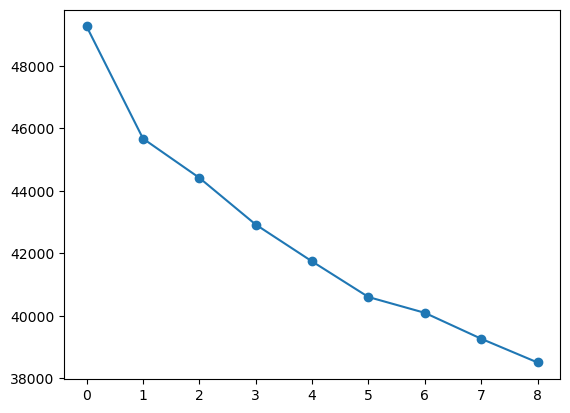

In [33]:
wcss_1 = []                                     
range_values = range(1, 10)                    
for i in range_values:                        
  kmeans = KMeans(n_clusters=i)                 
  kmeans.fit(X_std3)            
  wcss_1.append(kmeans.inertia_) 

grafico = px.line(x = range(1,10), y = wcss_1)
plt.plot(wcss_1, '-o',)  
grafico.show()

In [34]:
k = 4

# Compute KMeans
kmeans_std3 = KMeans(n_clusters = k, n_init=1, init = 'random', max_iter=50).fit(X_std3)

# Compute KMeans++
kmeans_plus_std3 = KMeans(n_clusters = k, n_init=1, init = 'k-means++', max_iter=50).fit(X_std3)
labels_kmeans_std3 = kmeans_std3.labels_
labels_kmeans_plus_std3 = kmeans_plus_std3.labels_

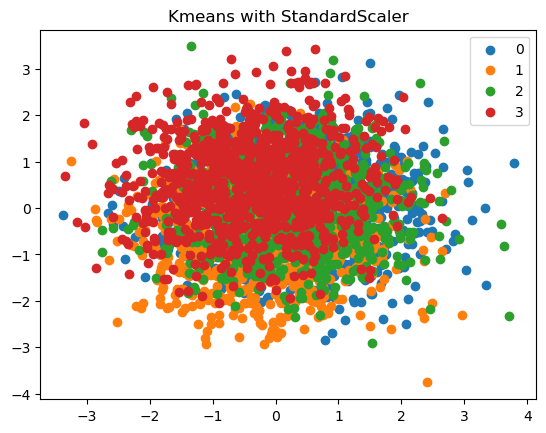

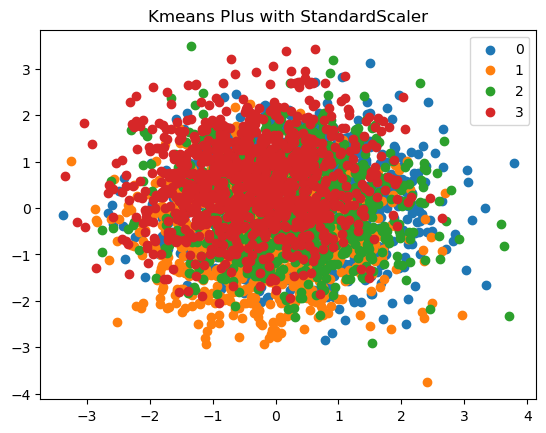

Inertia k-Means with StandardScaler: 42589.9598039233
Inertia k-Means++ with StandardScaler: 42727.64606848457
Silhouette_score k-Means with StandardScaler : 0.061402056985803734
Davies_bouldin_score k-Means with StandardScaler : 3.511348567293481
Silhouette_score k-Means++ with StandardScaler: 0.058198218070481936
Davies_bouldin_score k-Means++ with StandardScaler : 3.693695184843941


In [35]:
u_labels = np.unique(labels_kmeans_std3)

for i in u_labels:
    xy = X_std3[labels_kmeans_plus_std3 == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans with StandardScaler')
plt.show()

u_labels = np.unique(labels_kmeans_plus_std3)

for i in u_labels:
    xy = X_std3[labels_kmeans_plus_std3 == i]
    plt.scatter(xy[: , 0] ,xy[: , 1] , label = i)
plt.legend()
plt.title('Kmeans Plus with StandardScaler')
plt.show()

print("Inertia k-Means with StandardScaler:", kmeans_std3.inertia_)
print("Inertia k-Means++ with StandardScaler:", kmeans_plus_std3.inertia_)
print("Silhouette_score k-Means with StandardScaler :",silhouette_score(X_std3, labels_kmeans_std3))
print("Davies_bouldin_score k-Means with StandardScaler :",davies_bouldin_score(X_std3, labels_kmeans_std3))
print("Silhouette_score k-Means++ with StandardScaler:",silhouette_score(X_std3, labels_kmeans_plus_std3))
print("Davies_bouldin_score k-Means++ with StandardScaler :",davies_bouldin_score(X_std3, labels_kmeans_plus_std3))

In [36]:
#Hierarchical Approach
agglo_single_std = AgglomerativeClustering(linkage='single',n_clusters=3).fit(X_std)
agglo_avg_std = AgglomerativeClustering(linkage='average',n_clusters=3).fit(X_std)
agglo_single_mm = AgglomerativeClustering(linkage='single',n_clusters=3).fit(X_mm)
agglo_avg_mm = AgglomerativeClustering(linkage='average',n_clusters=3).fit(X_mm)

labels_agglo_std = agglo_single_std.labels_
labels_agglo_avg_std = agglo_avg_std.labels_
labels_agglo_mm = agglo_single_mm.labels_
labels_agglo_avg_mm = agglo_avg_mm.labels_


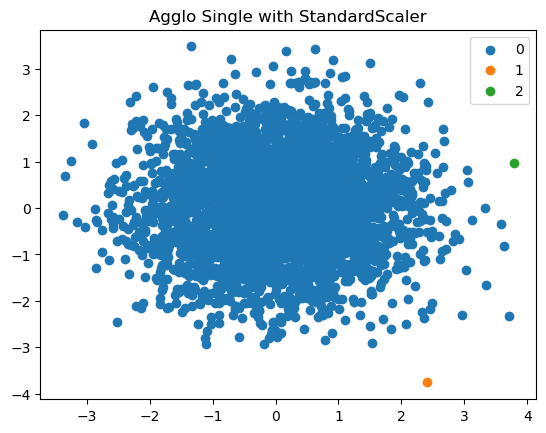

Silhouette_score Agglo Single with StandardScaler : 0.46972086929896806
Davies_bouldin_score Agglo Single with StandardScaler : 0.3234938024245649


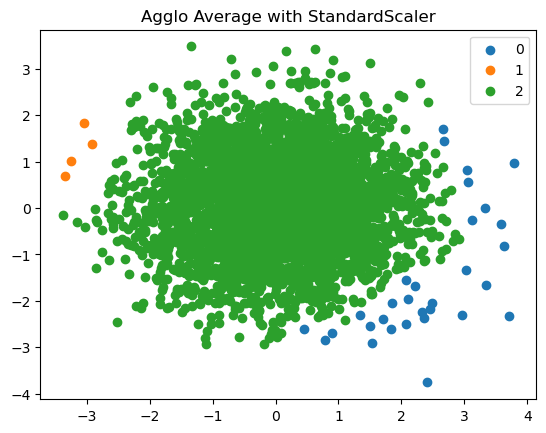

Silhouette_score Agglo Average with StandardScaler: 0.3080921465821257
Davies_bouldin_score Agglo Average with StandardScaler : 0.8152515536746449


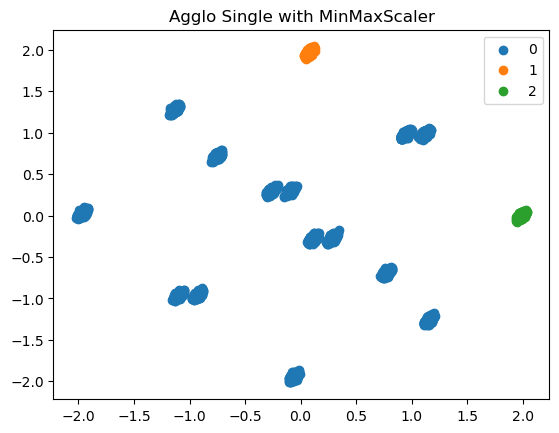

Silhouette_score Agglo Single with MinMaxScaler : 0.2257954929041331
Davies_bouldin_score Agglo Single with MinMaxScaler : 0.571512306936083


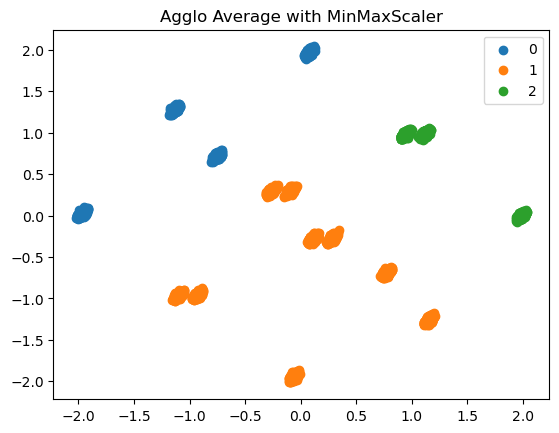

Silhouette_score Agglo Average with MinMaxScaler: 0.4239236322479167
Davies_bouldin_score Agglo Average with MinMaxScaler : 0.9132925652748605


In [37]:
a_labels = np.unique(labels_agglo_std)

for i in a_labels:
    plt.scatter(X_std[labels_agglo_std == i , 0] , X_std[labels_agglo_std == i , 1] , label = i)
plt.legend()
plt.title('Agglo Single with StandardScaler')
plt.show()

print("Silhouette_score Agglo Single with StandardScaler :",silhouette_score(X_std, labels_agglo_std))
print("Davies_bouldin_score Agglo Single with StandardScaler :",davies_bouldin_score(X_std, labels_agglo_std))

a_labels = np.unique(labels_agglo_avg_std)

for i in a_labels:
    plt.scatter(X_std[labels_agglo_avg_std == i , 0] , X_std[labels_agglo_avg_std == i , 1] , label = i)
plt.legend()
plt.title('Agglo Average with StandardScaler')
plt.show()

print("Silhouette_score Agglo Average with StandardScaler:",silhouette_score(X_std, labels_agglo_avg_std))
print("Davies_bouldin_score Agglo Average with StandardScaler :",davies_bouldin_score(X_std, labels_agglo_avg_std))

a_labels = np.unique(labels_agglo_mm)

for i in a_labels:
    plt.scatter(X_mm[labels_agglo_mm == i , 0] , X_mm[labels_agglo_mm == i , 1] , label = i)
plt.legend()
plt.title('Agglo Single with MinMaxScaler')
plt.show()

print("Silhouette_score Agglo Single with MinMaxScaler :",silhouette_score(X_mm, labels_agglo_mm))
print("Davies_bouldin_score Agglo Single with MinMaxScaler :",davies_bouldin_score(X_mm, labels_agglo_mm))

a_labels = np.unique(labels_agglo_avg_mm)

for i in a_labels:
    plt.scatter(X_mm[labels_agglo_avg_mm == i , 0] , X_mm[labels_agglo_avg_mm == i , 1] , label = i)
plt.legend()
plt.title('Agglo Average with MinMaxScaler')
plt.show()

print("Silhouette_score Agglo Average with MinMaxScaler:",silhouette_score(X_mm, labels_agglo_avg_mm))
print("Davies_bouldin_score Agglo Average with MinMaxScaler :",davies_bouldin_score(X_mm, labels_agglo_avg_mm))

In [38]:
data_scaled = normalize(df_cleaning)
data_scaled = pd.DataFrame(data_scaled, columns = df_cleaning.columns)
data_scaled.head()

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,smoking_status
0,0.061,0.003,0.010,0.638,0.355,0.541,0.000,0.276,0.084,0.278,0.097,0.001,0.003,0.003,0.003
1,0.108,0.000,0.007,0.634,0.433,0.451,0.000,0.348,0.101,0.238,0.089,0.006,0.002,0.000,0.000
2,0.136,0.003,0.008,0.252,0.451,0.532,0.000,0.449,0.086,0.471,0.035,0.001,0.003,0.003,0.003
3,0.246,0.004,0.012,0.070,0.602,0.418,0.000,0.403,0.262,0.399,0.087,0.004,0.000,0.000,0.000
4,0.079,0.002,0.009,0.561,0.428,0.428,0.000,0.396,0.045,0.384,0.076,0.000,0.000,0.000,0.002


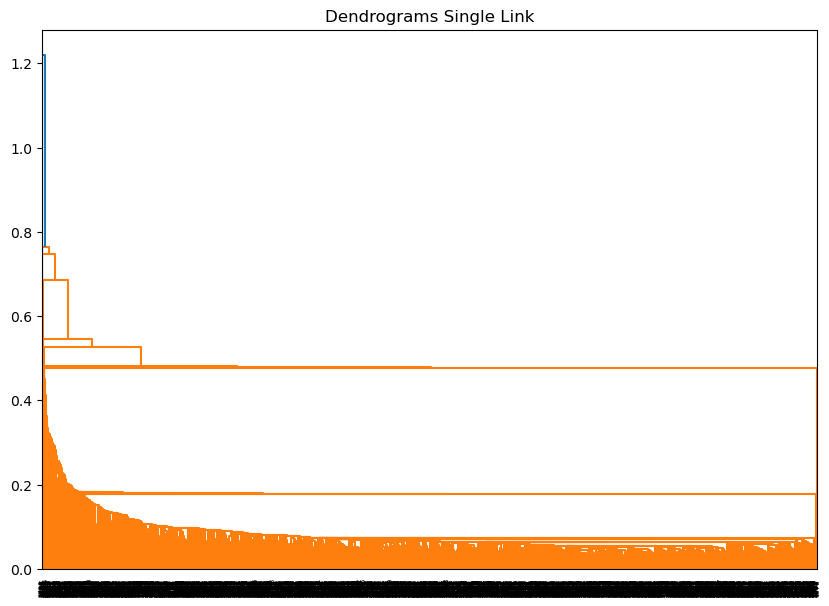

In [39]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Single Link")  
dend = shc.dendrogram(shc.linkage(X_std, method='single'))

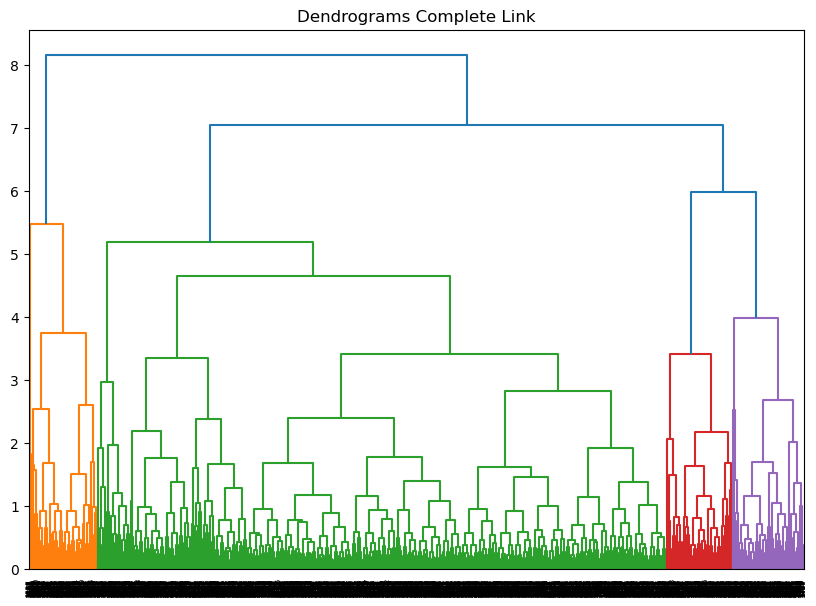

In [40]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Complete Link")  
dend = shc.dendrogram(shc.linkage(X_std, method='complete'))

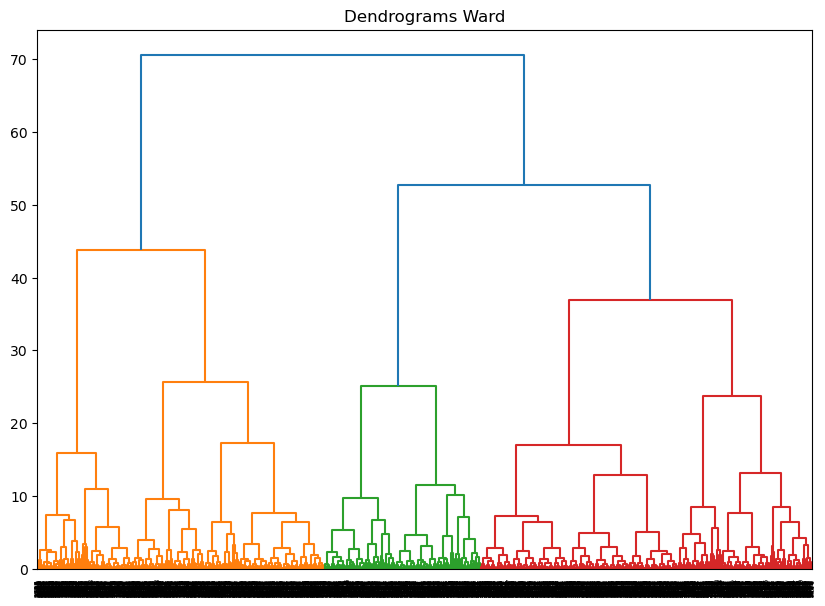

In [41]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Ward")  
dend = shc.dendrogram(shc.linkage(X_std, method='ward'))

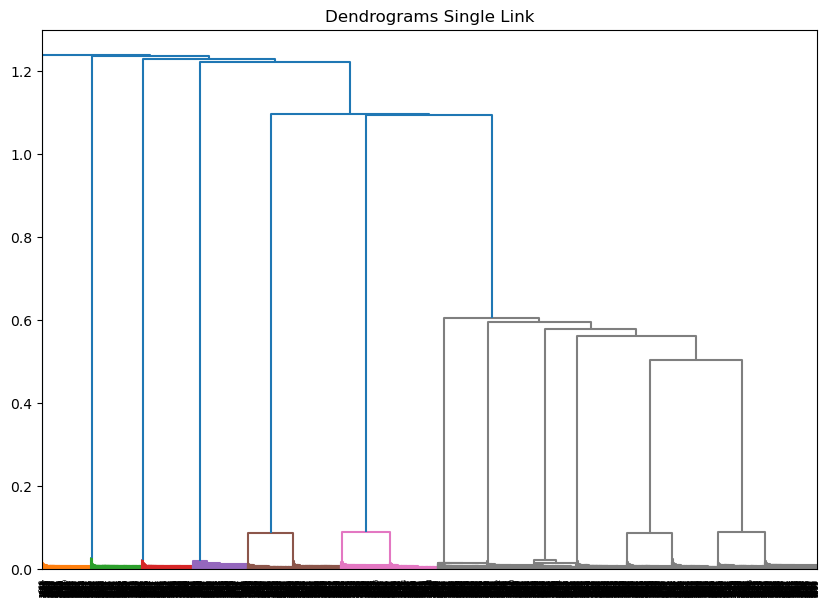

In [42]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Single Link")  
dend = shc.dendrogram(shc.linkage(X_mm, method='single'))

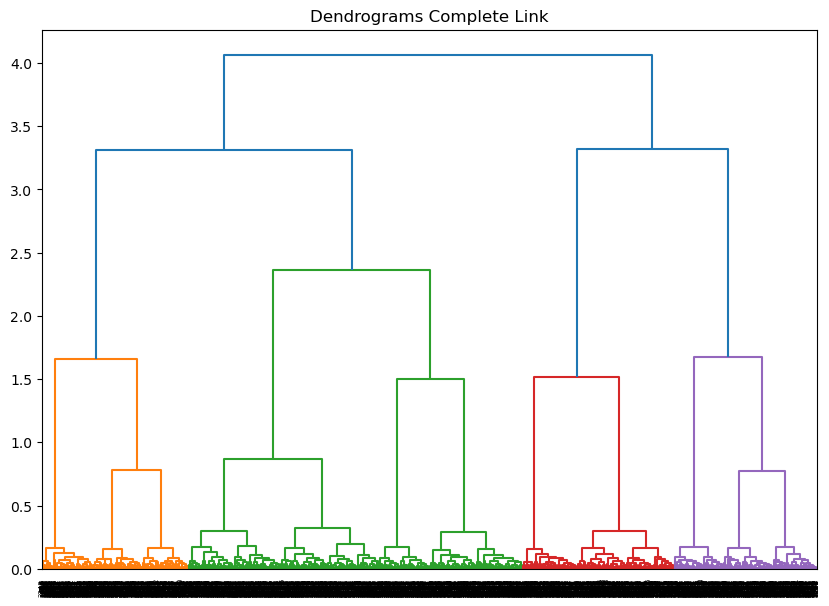

In [43]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Complete Link")  
dend = shc.dendrogram(shc.linkage(X_mm, method='complete'))

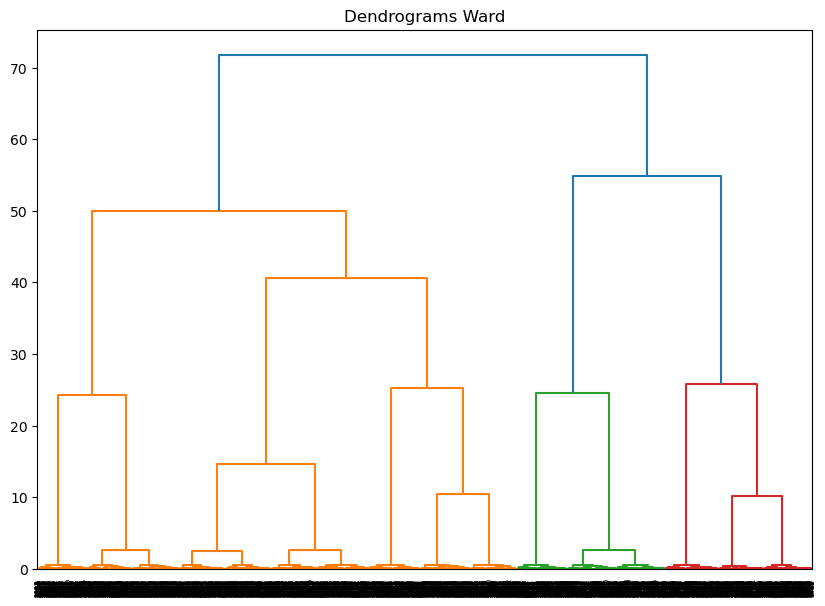

In [44]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms Ward")  
dend = shc.dendrogram(shc.linkage(X_mm, method='ward'))